In [1]:
%matplotlib inline

# Face recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

**TODO's**:

1. Run the existing code to compute pixel-based PCA and tSNE
2. Add a new feature option - Histogram of Gradients (HOG)
3. Compute and plot 2-component PCA for pixel and HOG features

**Discussion Q's**:
- How can we tell which feature option is the best for representing faces?
- Why are HOG features better than pixels?
- What seems to be the best way to plot and visualize our data? Why?

In [2]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from skimage.filters import sobel
from skimage.feature import hog

import torchvision.models as models
from torch import nn
from torchsummary import summary
from PIL import Image
from torchvision import transforms
import torch
print (f'torch.__version__: {torch.__version__}')

import tensorflow as tf




/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.__version__: 1.13.0


2022-12-01 15:16:36.472606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# load the labeled face in wild dataset from sklearn

In [3]:
# the min_faces_per_person dictates the number of classes
lfw_people = fetch_olivetti_faces()

# the label to predict is the id of the person
y = lfw_people.target

# keep only 20 classes
lfw_people.images = lfw_people.images[y<20, ...]
y = y[y<20]

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

n_classes = len(np.unique(y))

print("Total dataset size:")
print(f"n_samples, height, width: {n_samples}, {h}, {w}")
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples, height, width: 200, 64, 64
n_classes: 20


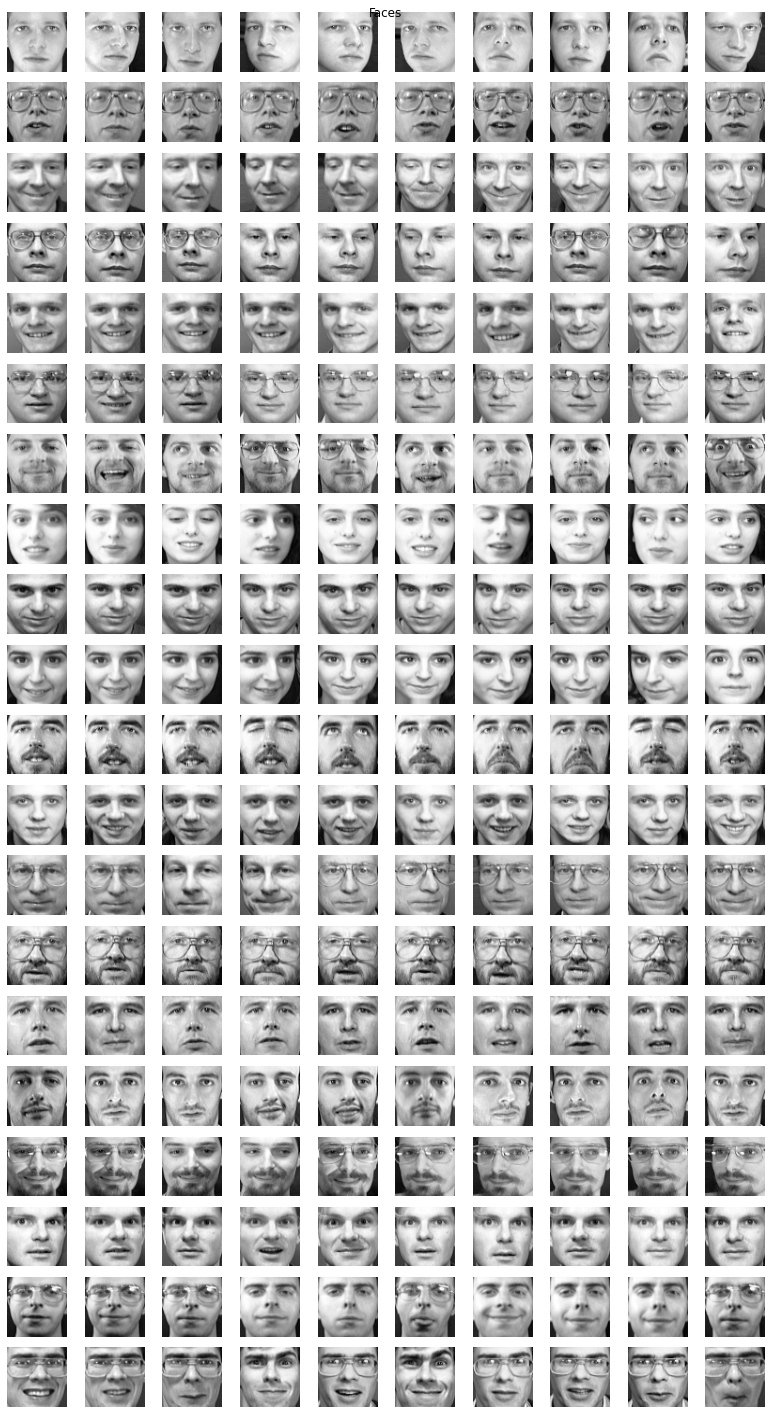

In [4]:
def show_images(images):
    fig, axes = plt.subplots(nrows=20, ncols=10, figsize=[11, 20], dpi=72)
    axes = axes.flatten()
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f'Faces')
    plt.tight_layout()
    plt.show()
show_images(lfw_people.images)

# extract features from images

In [5]:
class ResNet152(nn.Module):

    def __init__(self):
        super(ResNet152, self).__init__()
        
        # load the pretrained model
        self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        # select till the last layer
        # Dropping output layer (the ImageNet classifier)
        self.model = nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):

      x = self.model(x)
      return x

def get_cnn_features(in_imgs):
    out_feat = []
    print('Creating model')
    model_conv_features = ResNet152()
    print('Created model')
    for i in range(in_imgs.shape[0]):

      # convert the grayscale to RGB images
      cur_rgb = np.stack([in_imgs[i,:,:], in_imgs[i,:,:], in_imgs[i,:,:]], axis=2)
      if np.max(cur_rgb)>1:
        cur_rgb = cur_rgb.astype(np.uint8)
      else:
        cur_rgb = (cur_rgb*255).astype(np.uint8)
      
      # preprocess the image to prepare it for input to CNN
      preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
      out_im = preprocess(Image.fromarray(cur_rgb))
      out_feat.append(model_conv_features(out_im.unsqueeze(0).to('meta')).squeeze().detach().numpy())

      if i==0:
        print(out_feat[0].shape)
    return np.stack(out_feat, axis=0)

def get_cnn_features(in_imgs):
    out_feat = []
    print('Creating model')
    model_conv_features = ResNet152()
    print('Created model')
    for i in range(in_imgs.shape[0]):

      # convert the grayscale to RGB images
      cur_rgb = np.stack([in_imgs[i,:,:], in_imgs[i,:,:], in_imgs[i,:,:]], axis=2)
      if np.max(cur_rgb)>1:
        cur_rgb = cur_rgb.astype(np.uint8)
      else:
        cur_rgb = (cur_rgb*255).astype(np.uint8)
      
      # preprocess the image to prepare it for input to CNN
      preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
      out_im = preprocess(Image.fromarray(cur_rgb))
      out_feat.append(model_conv_features(out_im.unsqueeze(0).to('cpu')).squeeze().detach().numpy())

      if i==0:
        print(out_feat[0].shape)
    return np.stack(out_feat, axis=0)
    
def get_features(in_imgs, feat_name='pixels'):
  if feat_name == 'pixels':
    plt.figure(figsize=(5,5))
    plt.imshow(in_imgs[0, ...], cmap='gray')
    plt.axis('off')
    plt.show()
    return np.vstack([in_imgs[x,:,:].flatten()[np.newaxis, :] for x in range(in_imgs.shape[0])])
  
  if feat_name == 'hog':

    out_feat = []    
    for i in range(in_imgs.shape[0]):
        fd, hog_image = hog(in_imgs[i, :, :], orientations=4, pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        if i == 0:
          plt.figure(figsize=(5,5))
          plt.imshow(hog_image, cmap='gray')
          plt.axis('off')
          plt.show()
        out_feat.append(fd[np.newaxis, :])
    return np.vstack(out_feat)

  if feat_name == 'CNN':
    return get_cnn_features(in_imgs)
  return None


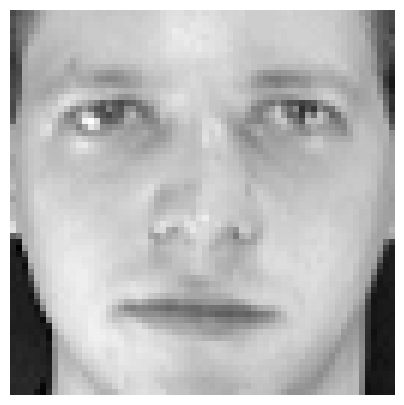

pixel_features:(200, 4096)


/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_20124/4057703641.py:86: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(in_imgs[i, :, :], orientations=4, pixels_per_cell=(8, 8),


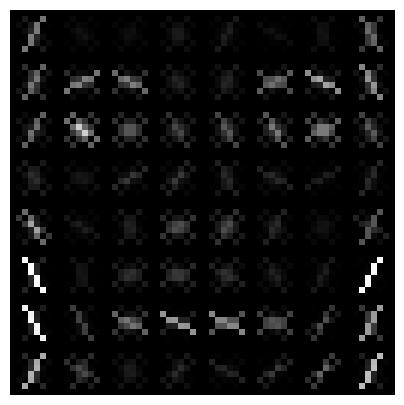

hog_features:(200, 784)
Creating model
Created model
(2048,)
CNN_features:(200, 2048)


In [6]:
#features
pixel_features = get_features(lfw_people.images, feat_name='pixels')
print(f'pixel_features:{pixel_features.shape}')
hog_features = get_features(lfw_people.images, feat_name='hog')
print(f'hog_features:{hog_features.shape}')
CNN_features = get_features(lfw_people.images, feat_name='CNN')
print(f'CNN_features:{CNN_features.shape}')

# dimensionality reduction

In [7]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'g-', 'r-']
  labels = ['pixel features', 'hog features', 'CNN features']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(b=True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_20124/436622564.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


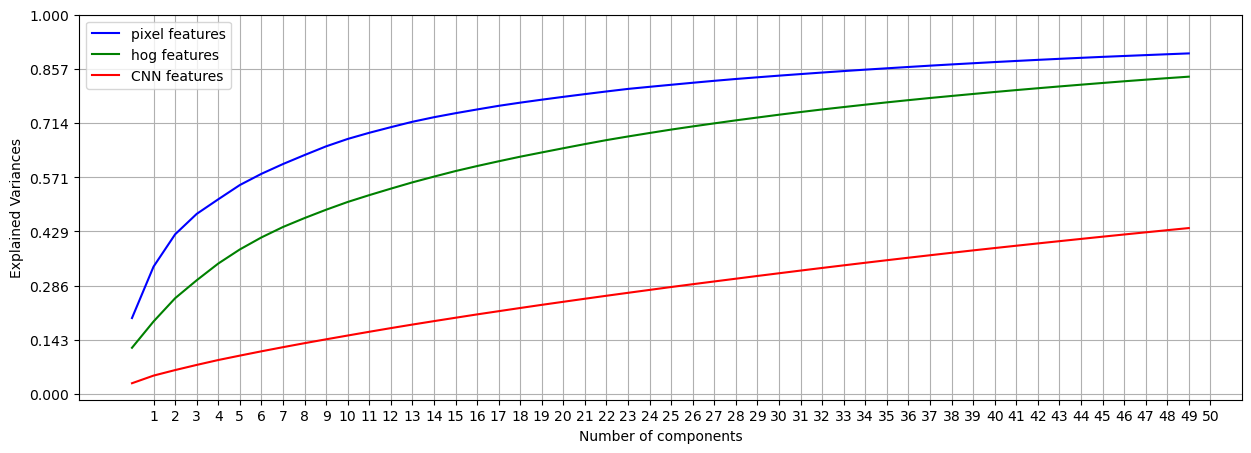

In [8]:
# plot explained variance vs the number of components for PCA
x = plot_PCA([pixel_features, hog_features, CNN_features], n_components=50)

In [9]:
# pixel dimensionality reduction (2D)
X_pixels_pca, X_hog_pca, X_CNN_pca = get_PCA([pixel_features, hog_features, CNN_features], n_components=2)[-1]
X_pixels_tsne, X_hog_tsne, X_CNN_tsne = get_tsne([pixel_features, hog_features, CNN_features], n_components=2)

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in T

# plot the features

In [18]:
def plot_classes(X, y, ax, title):

  colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  for k in range(len(np.unique(y))):
    if X.shape[1] == 2:
      ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])
    else:
      ax.scatter(X[y==k, 0], X[y==k, 1], X[y==k, 2], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

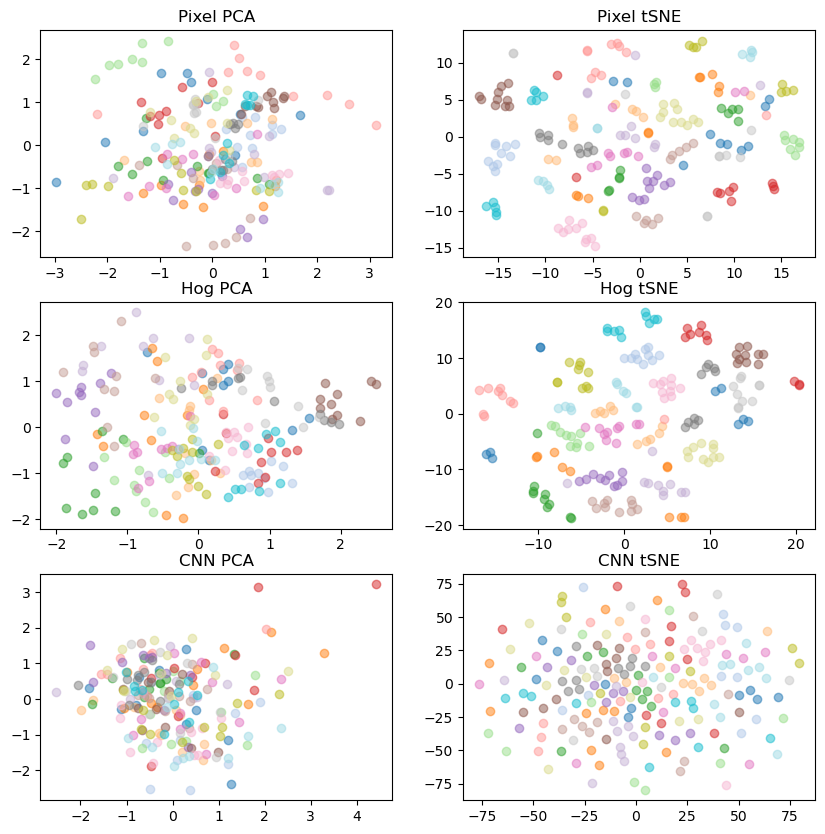

In [11]:
# project the features into 2 dimensions
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# y is the class labels
plot_classes(X_pixels_pca, y, ax[0,0], title='Pixel PCA')
plot_classes(X_pixels_tsne, y, ax[0,1], title='Pixel tSNE')
plot_classes(X_hog_pca, y, ax[1,0], title='Hog PCA')
plot_classes(X_hog_tsne, y, ax[1,1], title='Hog tSNE')
plot_classes(X_CNN_pca, y, ax[2,0], title='CNN PCA')
plot_classes(X_CNN_tsne, y, ax[2,1], title='CNN tSNE')
plt.show()

In [12]:
# TODO: Compare and discuss the classification accuracy using nonparametric kNN algorithm

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_pixels_pca, y)
pixels_pca_accuracy = 0
for i in range(n_samples):
    label = knn.predict([X_pixels_pca[i,:]])
    if label[0] == y[i]:
        pixels_pca_accuracy +=1
print('Pixel PCA Accuracy: ', pixels_pca_accuracy/n_samples)

knn.fit(X_pixels_tsne, y)
pixels_tsne_accuracy = 0
for i in range(n_samples):
    label = knn.predict([X_pixels_tsne[i,:]])
    if label[0] == y[i]:
        pixels_tsne_accuracy +=1
print('Pixel tSNE Accuracy: ', pixels_tsne_accuracy/n_samples)

knn.fit(X_hog_tsne, y)
HOG_tsne_accuracy = 0
for i in range(n_samples):
    label = knn.predict([X_hog_tsne[i,:]])
    if label[0] == y[i]:
        HOG_tsne_accuracy +=1
print('HOG tSNE Accuracy: ', HOG_tsne_accuracy/n_samples)

knn.fit(X_CNN_tsne, y)
CNN_tsne_accuracy = 0
for i in range(n_samples):
    label = knn.predict([X_CNN_tsne[i,:]])
    if label[0] == y[i]:
        CNN_tsne_accuracy +=1
print('CNN tSNE Accuracy: ', CNN_tsne_accuracy/n_samples)


Pixel PCA Accuracy:  0.6
Pixel tSNE Accuracy:  0.95
HOG tSNE Accuracy:  0.98
CNN tSNE Accuracy:  0.67


# Classification

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform


In [14]:

# get the train and test split
train_idx, val_idx = train_test_split(np.arange(len(lfw_people.images)), test_size=0.25, random_state=42)


In [15]:

def train_classifier(in_feat, in_y, in_train_idx, val_idx):

  # get the train and validation split
  X_train = in_feat[in_train_idx, :].copy()
  y_train = in_y[in_train_idx].copy()
  X_val = in_feat[val_idx, :].copy()
  y_val = in_y[val_idx].copy()

  # scaling
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)

  # classifier with cross validation
  param_grid = {"C": loguniform(1e-3, 1e5)}
  clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid, n_iter=10)
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  return accuracy_score(y_val, y_pred)


In [16]:

print('Pixel Feature Accuracy')
n_components = 20
# get accuracy with different features
pixel_acc = []
for n in range(n_components):
  _, X = get_PCA([pixel_features], n_components=n+1)
  pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))

print('HOG Feature Accuracy')
hog_acc = []
for n in range(n_components):
  _, X = get_PCA([hog_features], n_components=n+1)
  hog_acc.append(train_classifier(X[0], y, train_idx, val_idx))
hog_acc.append(train_classifier(hog_features, y, train_idx, val_idx))

print('CNN Feature Accuracy')
CNN_acc = []
for n in range(n_components):
  _, X = get_PCA([CNN_features], n_components=n+1)
  CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))


Pixel Feature Accuracy


/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:68

HOG Feature Accuracy


/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:68

CNN Feature Accuracy


/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:68

/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_20124/1043123825.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


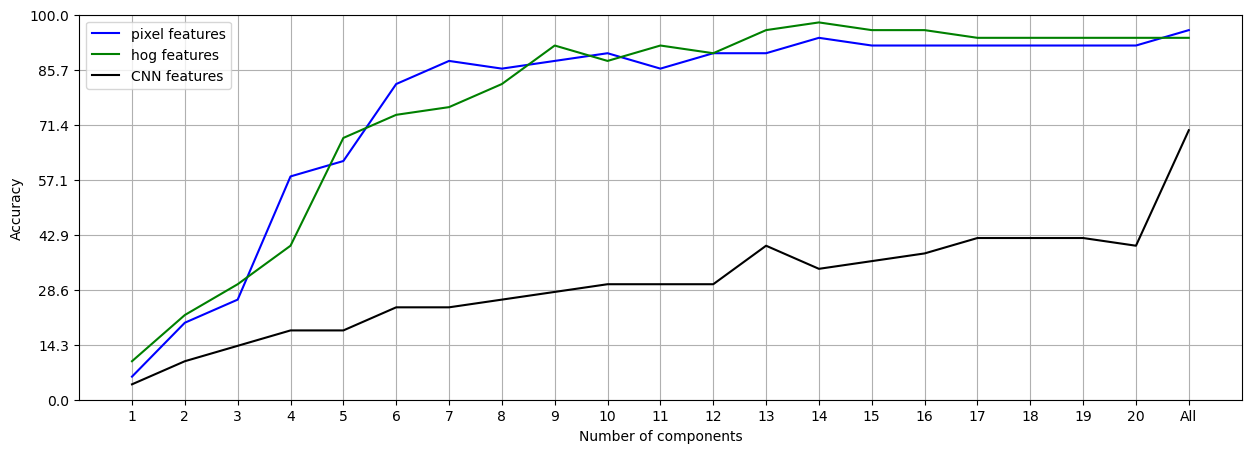

In [17]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
plt.plot(np.array(hog_acc)*100, 'g-', label='hog features')
plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

xtick_labels = [f'{i+1}' for i in range(n_components)] + ['All']
plt.xticks(np.arange(n_components+1), labels=xtick_labels)
plt.yticks(np.linspace(0, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()
